# Threshold optimization 

Jukes Liu

## Import packages and set paths

In [2]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import matplotlib.pylab as pl
import numpy.ma as ma
import datetime
import math
import scipy.optimize
import time
import random

In [3]:
basepath = '/media/jukes/jukes1/'
sg_path = '/home/jukes/Documents/Sample_glaciers/'

## Read in analysis dates for manual and automated delinations, convert to datetime objs

In [3]:
# #read in manual image dates
# manual_df= pd.read_csv(basepath+'Manual/manual_tpos.csv', sep=',', dtype=str, header=0)
# manual_df = manual_df.dropna()
# manual_df.drop_duplicates(subset=['BoxID','datetimes'])
# print(manual_df.shape)
# manual_df.head()

In [4]:
# #Read in datetags csv as datetime_df
# automated_df = pd.read_csv(sg_path+'imgdates.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])
# print(automated_df.shape)
# automated_df.head()

## Find overlaps and select 90% for training, 10% for testing

In [5]:
# overlap_df = manual_df.merge(automated_df, how='inner', on=['datetimes'])
# overlap_df = overlap_df.drop(['Line_x', 'Line_y'], axis=1)
# overlap_df = overlap_df.drop_duplicates(['BoxID','datetimes'])
# overlap_df = overlap_df.sort_values(by=['BoxID','datetimes'], ascending=True)
# overlap_df.shape

In [6]:
# dates = []
# for idx, row in overlap_df.iterrows():
#     dateID = str(row['BoxID'])+','+str(row['datetimes']+','+str(row['Scene']))
#     dates.append(dateID)
# # print(date_IDs)

### Select 90% for training

In [7]:
# N = len(dates); print(N)

# #pick a random sample of dates for training
# train_dates = random.sample(dates, int(N*0.9))
# print(len(train_dates))
# # print(train_dates)

# #grab remaining for testing
# test_dates = []
# for date in dates:
#     if date not in train_dates:
#         test_dates.append(date)
# print(len(test_dates))
# # print(test_dates)

# #Check that they don't overlap, should return empty
# print(len(train_dates)+len(test_dates)); print(set(train_dates).intersection(test_dates))

In [8]:
# boxes = []; imgdates = []; scenes = []

# for td in train_dates:
#     BoxID, imgdate, scene = td.split(',')
#     boxes.append(BoxID); imgdates.append(imgdate); scenes.append(scene)

# train_df = pd.DataFrame(list(zip(boxes, imgdates, scenes)), columns=['BoxID', 'datetime', 'Scene'])
# train_df.head()

In [ ]:
# #export to csv and text
# train_df.to_csv(basepath+'/Manual/train.csv', sep=',', index=False, header=False)
# train_df.to_csv(basepath+'/Manual/train.txt', sep=' ', index=False, header=False)

### Grab test dates

In [ ]:
# boxes = []; imgdates = []; scenes = []

# for td in test_dates:
#     BoxID, imgdate, scene = td.split(',')
#     boxes.append(BoxID); imgdates.append(imgdate); scenes.append(scene)

# test_df = pd.DataFrame(list(zip(boxes, imgdates, scenes)), columns=['BoxID', 'datetime', 'Scene'])
# # test_df.head()
# #export to csv and text
# test_df.to_csv(basepath+'/Manual/test.csv', sep=',', index=False, header=False)
# test_df.to_csv(basepath+'/Manual/test.txt', sep=' ', index=False, header=False)

## Define objective function

I'm using a modified version of the L1-norm. Imported from the automated_terminus_functions.py script. The objective funciton will be 1/N * (|Xa-Xm|i) where i=3 (for each centerline 50, 25, 75) and N equals the number of delineations generated (the more the better). The goal then is to minimize the objective function.

In [ ]:
# DOA = '2020_01_20'

# def calc_theta(size_thresh, mod_thresh):
#     #Calculate automated tpos
#     #run terminus_pick.tcl using each of the thresholds
#     terminus_pick = '/home/akhalil/src/xsmurf-2.7/main/xsmurf -nodisplay /home/jukes/Documents/Scripts/terminus_pick.tcl '+str(size_thresh)+' '+str(mod_thresh)
#     print(terminus_pick)
#     subprocess.call(terminus_pick, shell=True)
    
#     #pull automated terminus position from the output
#     #grab each output file
#     differences = []
    
#     for file in os.listdir(sg_path):
#         if DOA in file and file.endswith('csv'):
#             if len(file)>28:
#                 print(file)

#                 #read the output file in and calculate terminus position for each image
#                 #pull automated terminus delineations
#                 auto_tpos = 

#                 #pull in manual tpos 
#                 man_tpos = 

#                 diff = abs(auto_tpos - man_tpos)
#                 differences.append(diff)
    
# #     #return objective function = distance between the two
# #     return np.average(differences)

In [ ]:
# def minimize(size_guess, mod_guess):
#     minimum = scipy.optimize.fmin(center_dist, [size_guess, mod_guess], args=(size_guess, mod_guess),full_output=True)
#     xopt = minimum[0][0]
#     funcval = minimum[1]
#     return xopt, funcval

## Run the optimization

    scipy.optimize.fmin(func, x0, args=(), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None)[source]

Minimize a function using the downhill simplex algorithm.
This algorithm only uses function values, not derivatives or second derivatives.

Parameters
   - funccallable func(x,*args)
The objective function to be minimized.

   - x0ndarray
Initial guess.

Returns
   - xoptndarray
Parameter that minimizes function.

   - foptfloat
Value of function at minimum: fopt = func(xopt).

   - iterint
Number of iterations performed.

   - funcallsint
Number of function calls made.

   - warnflagint
1 : Maximum number of function evaluations made. 2 : Maximum number of iterations reached.

    -allvecslist
Solution at each iteration.

In [16]:
#import objective function
os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import objective_func, calc_theta

In [17]:
#create the thresholds to input into the objective function
base_size_thresh = 0.7; base_mod_thresh = 0.7; base_arg_thresh = 0.3;
thresh_range = 0.2; step=0.1;
size_guesses = np.arange(base_size_thresh-thresh_range, base_size_thresh+thresh_range+step, step)
mod_guesses = np.arange(base_mod_thresh-thresh_range, base_mod_thresh+thresh_range+step, step)
arg_guesses = np.arange(base_arg_thresh-thresh_range, base_arg_thresh+thresh_range+step, step)
# display the threshold guesses
print(size_guesses); print(mod_guesses); print(arg_guesses)

[0.5 0.6 0.7 0.8 0.9]
[0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.3 0.4 0.5]


In [22]:
# create list of thresholding orders to test
# orders = ['_AMS', '_ASM', '_MAS', '_MSA', '_MSA', '_SAM', '_SMA']
orders = ['_SAM', '_SMA']
n_iter = len(orders)*len(size_guesses)*len(mod_guesses)*len(arg_guesses)
print(n_iter, 'iterations'); print(n_iter*20/60, "max hours to run")

250 iterations
83.33333333333333 max hours to run


In [23]:
type(" ".join(['001', '002', '120', '174', '259']))

str

### Hard-coded:

In [ ]:
import subprocess
import pandas as pd; import numpy as np
import time

# BoxIDs = " ".join(['001', '002', '120', '174', '259']); print(IDs)
start_time = time.time() #start recording time

slist = []; mlist = []; alist = []; orderlist = []; thetalist = []; runtimes = []; #store run results

for order in orders:
    for s in size_guesses:
        for m in mod_guesses:
            for a in arg_guesses:
                t0 = time.time() # start recording time for each run
                # make sure precision and format is correct for the thresholds
                s = float("{0:.3f}".format(s)); m = float("{0:.3f}".format(m)); a = float("{0:.3f}".format(a));
                print(order[1:4], s, m, a)
                #append the thresholds and order to lists
                slist.append(s); mlist.append(m); alist.append(a); orderlist.append(order[1:4]) 
                
                #run objective function calculation
                theta = objective_func(s, m, a, order); print(theta); thetalist.append(theta)

                runtime = time.time() - t0; runtimes.append(runtime) # calculate run time and store
                print("Iteration run time: %s seconds " % runtime) #print run time for each iteration
        
print("Total time elapsed: --- %s seconds ---" % (time.time() - start_time)) #Print total time elapsed

SAM 0.5 0.5 0.1
28.11265058587917
Iteration run time: 725.4507653713226 seconds 
SAM 0.5 0.5 0.2
28.596003522069218
Iteration run time: 767.7209167480469 seconds 
SAM 0.5 0.5 0.3
27.406664180598362
Iteration run time: 549.1619982719421 seconds 
SAM 0.5 0.5 0.4
27.29064590880609
Iteration run time: 451.4637260437012 seconds 
SAM 0.5 0.5 0.5
26.306328567761064
Iteration run time: 386.86916041374207 seconds 
SAM 0.5 0.6 0.1
28.981708944470988
Iteration run time: 819.1752007007599 seconds 
SAM 0.5 0.6 0.2
27.569630449970653
Iteration run time: 778.1089544296265 seconds 
SAM 0.5 0.6 0.3
27.365538773444776
Iteration run time: 519.129912853241 seconds 
SAM 0.5 0.6 0.4
26.645981098934033
Iteration run time: 426.98628211021423 seconds 
SAM 0.5 0.6 0.5
26.645981098934033
Iteration run time: 346.72516083717346 seconds 
SAM 0.5 0.7 0.1
27.693132785264726
Iteration run time: 811.4368374347687 seconds 
SAM 0.5 0.7 0.2
27.005666278924412
Iteration run time: 650.9988329410553 seconds 
SAM 0.5 0.7 0.3


In [12]:
optimization_df = pd.DataFrame(list(zip(thetalist, orderlist, slist, mlist, alist, runtimes)), 
                               columns=['Theta', 'Order', 'Size_thresh', 'Mod_thresh', 'Arg_thresh','run_time'])
optimization_df

,Theta,Order,Size_thresh,Mod_thresh,Arg_thresh,run_time
0,26.282047,AMS,0.5,0.5,0.1,250.426890
1,26.282047,AMS,0.5,0.5,0.2,249.570597
2,26.282047,AMS,0.5,0.5,0.3,228.628392
3,26.282047,AMS,0.5,0.5,0.4,220.598381
4,26.424514,AMS,0.5,0.5,0.5,183.725648
5,26.424514,AMS,0.5,0.6,0.1,207.791198
6,26.424514,AMS,0.5,0.6,0.2,192.693135
7,26.503489,AMS,0.5,0.6,0.3,201.553125
8,26.503489,AMS,0.5,0.6,0.4,180.051195
9,26.503489,AMS,0.5,0.6,0.5,173.390613


In [13]:
optimization_df[optimization_df['Theta'] == np.min(optimization_df['Theta'])]

,Theta,Order,Size_thresh,Mod_thresh,Arg_thresh,run_time
26,23.877875,AMS,0.6,0.5,0.2,213.157817


In [14]:
optimization_df.to_csv(sg_path+'optimizationresults_order.csv', sep=',')

# Visualize optimization results

Results from calculating mistfits between automated and manual delineations based on different thresholds used for filtering the WTMM lines. The two thresholds shown here are the size (length) threshold and the mod (gradient value) threshold, which are percentages of the maximum size/mod. So ideally, for 1 parameter (one threshold), the results should look like a parabola. For two 2 parameters like used here, one can visualize it in 3D. 

In [4]:
#plot results
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

#activate interactive widgets for plots:
%matplotlib notebook

path = '/Users/julialiu/Documents/BSU/EGG/'

In [6]:
df1 = pd.read_csv(sg_path+'optimizationresults_order.csv', sep=',')
df2 = pd.read_csv(sg_path+'optimizationresults_order2.csv', sep=',')
# df3 = pd.read_csv(sg_path+'optimizationresults_1.csv', sep=',')
# df4 = pd.read_csv(sg_path+'optimizationresults_4.csv', sep=',')
# optimization_df = pd.concat([df1, df2, df3, df4])
optimization_df = pd.concat([df1, df2])
# optimization_df = pd.read_csv(path+'optimizationresults_all4.csv', sep=',')

In [7]:
optimization_df

,Unnamed: 0,Theta,Order,Size_thresh,Mod_thresh,Arg_thresh,run_time
0,0,26.282047,AMS,0.5,0.5,0.1,250.426890
1,1,26.282047,AMS,0.5,0.5,0.2,249.570597
2,2,26.282047,AMS,0.5,0.5,0.3,228.628392
3,3,26.282047,AMS,0.5,0.5,0.4,220.598381
4,4,26.424514,AMS,0.5,0.5,0.5,183.725648
5,5,26.424514,AMS,0.5,0.6,0.1,207.791198
6,6,26.424514,AMS,0.5,0.6,0.2,192.693135
7,7,26.503489,AMS,0.5,0.6,0.3,201.553125
8,8,26.503489,AMS,0.5,0.6,0.4,180.051195
9,9,26.503489,AMS,0.5,0.6,0.5,173.390613


In [ ]:
# optimization_df.to_csv(sg_path+'optimizationresults_all4.csv', sep=',')

Separate by Order

In [50]:
order = 'SAM'
order_df = optimization_df[optimization_df['Order']==order]
# order_df

In [51]:
x = order_df['Size_thresh']
y = order_df['Mod_thresh']
z = order_df['Arg_thresh']
theta = order_df['Theta']


<IPython.core.display.Javascript object>


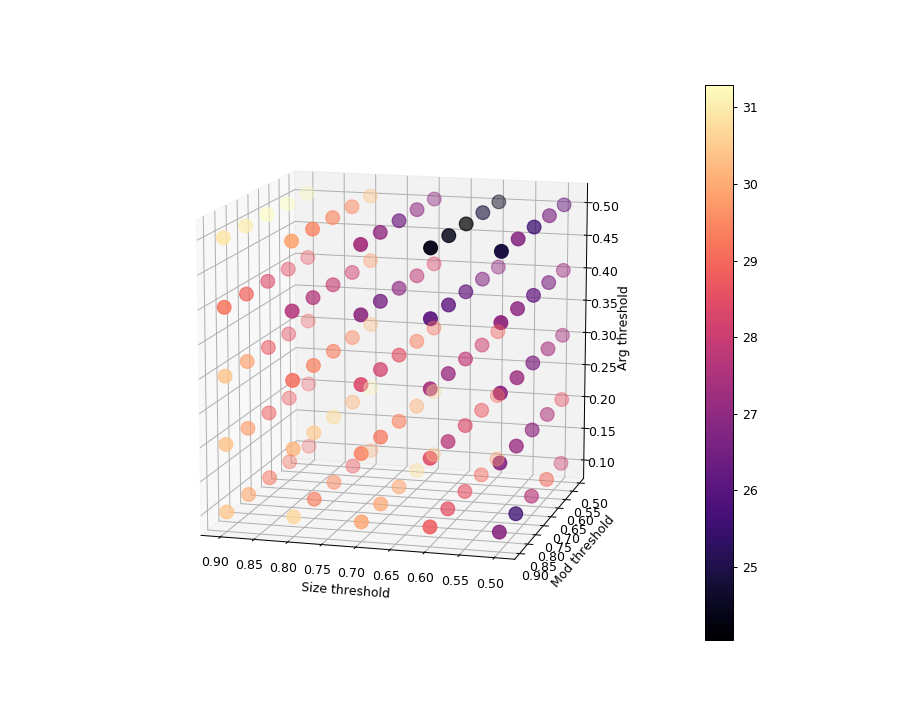

In [52]:
# 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')

# ax.plot_trisurf(triang, z, cmap='hot') # plot the surface over the mesh
plot = ax.scatter(x,y,z, marker='o', s=120, c=theta, cmap='magma') # plot the points
ax.view_init(elev=20, azim=45) # set initial view angle
fig.colorbar(plot)

ax.set_xlabel('Size threshold')
ax.set_ylabel('Mod threshold')
ax.set_zlabel('Arg threshold')
plt.show()

In [47]:
# x = optimization_df['Size_thresh']
# y = optimization_df['Arg_thresh']
# z = optimization_df['Theta']

x = order_df['Size_thresh']
y = order_df['Arg_thresh']
z = order_df['Theta']


<IPython.core.display.Javascript object>


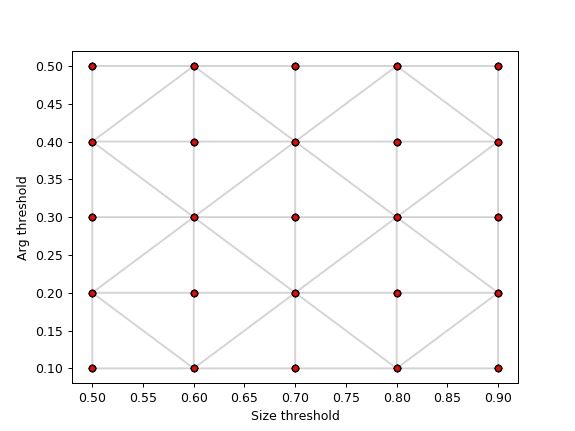

In [48]:
triang = mtri.Triangulation(x, y)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.triplot(triang, c="#D3D3D3", marker='.', markerfacecolor="r", markeredgecolor="black", markersize=10)
ax.set_xlabel('Size threshold')
ax.set_ylabel('Arg threshold')
plt.show()

<IPython.core.display.Javascript object>


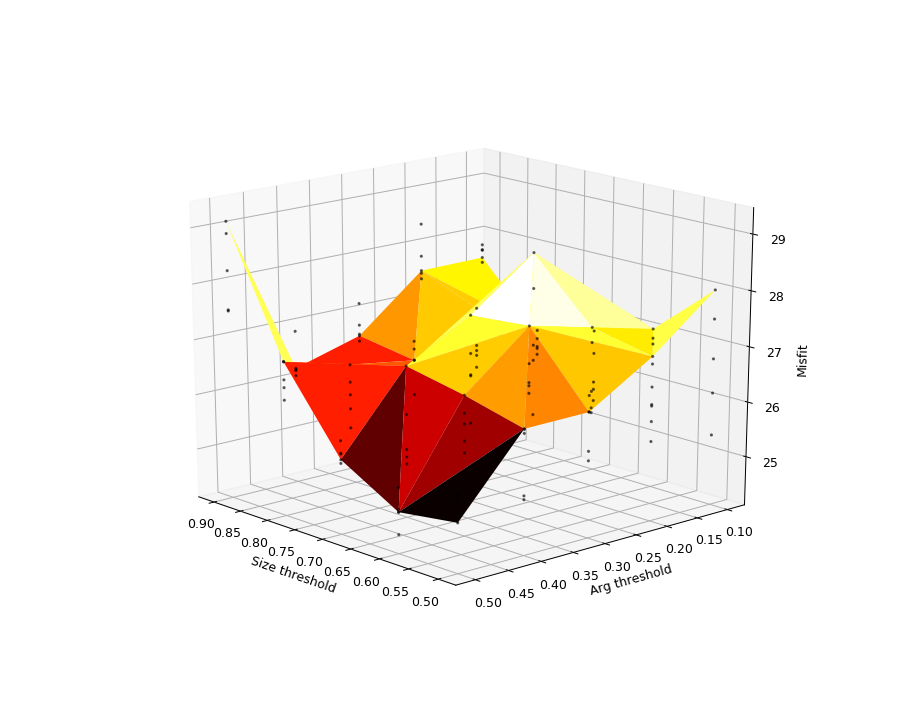

In [46]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot_trisurf(triang, z, cmap='hot') # plot the surface over the mesh
ax.scatter(x,y,z, marker='.', s=10, c="k", alpha=0.5) # plot the points
ax.view_init(elev=20, azim=45) # set initial view angle

ax.set_xlabel('Size threshold')
ax.set_ylabel('Arg threshold')
ax.set_zlabel('Misfit')
plt.show()

<IPython.core.display.Javascript object>


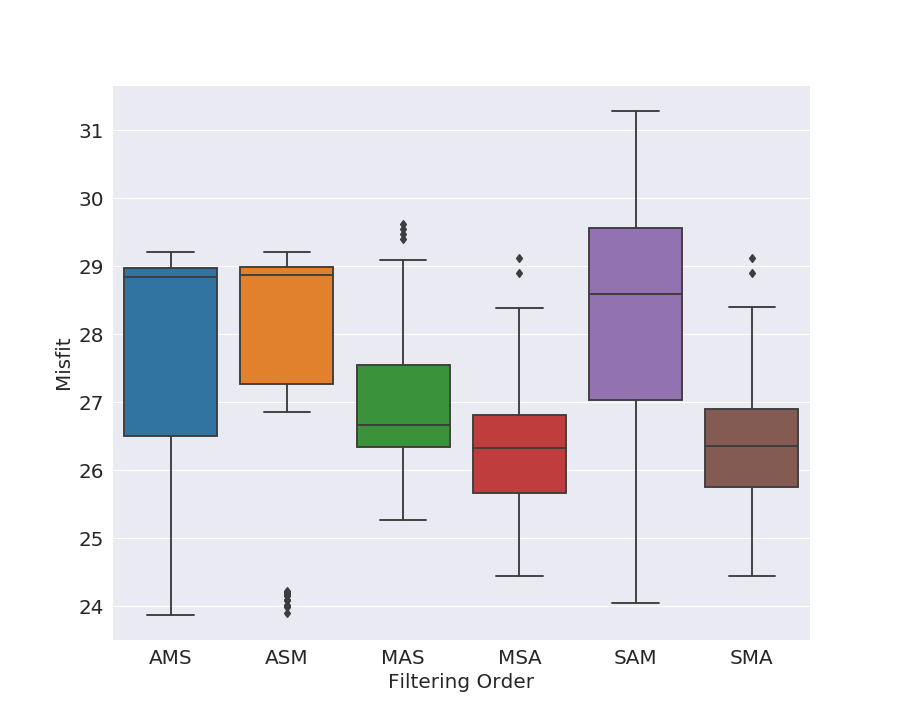

In [13]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
ax = sns.boxplot(x = 'Order', y = 'Theta', data=optimization_df)
plt.ylabel('Misfit', fontsize=16); plt.xlabel('Filtering Order', fontsize=16)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
plt.savefig(sg_path+'Misfit_by_order.png', dpi=200)
plt.show()

## Cross-validation